# Proton data in dilepton events

### Install packages

In [1]:
#!python3 -m pip install --user uproot4 awkward1 mplhep

In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep

### N-tuple processing

The data is first processed from a ROOT n-tuple. Below is an n-tuple from an MC sample.  
Look for the _ProtCand_ data defining the proton objects.

In [3]:
import uproot4
import awkward1 as ak

root = uproot4.open( "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/MC-2017-v1/output_exclusive_new.root" )
tree = root["ggll_miniaod/ntp1"]

keys = ["Run", "LumiSection", "BX", "EventNum", "CrossingAngle","nHLT", "HLT_Accept", "HLT_Prescl", "HLT_Name",
        "nMuonCand", "MuonCand_pt", "MuonCand_eta", "MuonCand_phi", "MuonCand_e", "MuonCand_charge", "MuonCand_vtxz", "MuonCand_istight",
        "nPrimVertexCand", "PrimVertexCand_z", "PrimVertexCand_chi2", "PrimVertexCand_ndof", "PrimVertexCand_tracks",
        "Weight", "PUWeightTrue"]
keys.append( "nPfCand" )
keys.extend( tree.keys( filter_name="PfCand*" ) ) 
keys.append( "nRecoProtCand" )
keys.extend( tree.keys( filter_name="ProtCand*" ) )

arrays = tree.arrays( keys, library="ak", how="zip", entry_stop=10000 )
#ak.to_list( arrays[:10] )
ak.to_list( arrays[100] )

{'Run': 1,
 'LumiSection': 2,
 'BX': 4294967295,
 'EventNum': 101,
 'CrossingAngle': -999.0,
 'nHLT': 3,
 'HLT_Name': ['HLT_DoubleMu43NoFiltersNoVtx_*',
  'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8_*',
  'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8_*'],
 'nMuonCand': 2,
 'nPrimVertexCand': 46,
 'Weight': 0.07034087051649685,
 'PUWeightTrue': 0.0,
 'nPfCand': 35,
 'nRecoProtCand': 3,
 'HLT': [{'Accept': 1, 'Prescl': 1},
  {'Accept': 1, 'Prescl': 1},
  {'Accept': 1, 'Prescl': 1}],
 'MuonCand': [{'pt': 65.17974090576172,
   'eta': -0.4599905014038086,
   'phi': 0.1109742596745491,
   'e': 72.19800061820877,
   'charge': 1,
   'vtxz': -5.768570423126221,
   'istight': 1},
  {'pt': 64.1058120727539,
   'eta': 2.116694688796997,
   'phi': -3.0283780097961426,
   'e': 270.01610419331763,
   'charge': -1,
   'vtxz': -5.77878999710083,
   'istight': 1}],
 'PrimVertexCand': [{'z': -5.767121315002441,
   'chi2': 3.3695783615112305,
   'ndof': 2,
   'tracks': 0},
  {'z': -0.030611446127295494,
   

The n-tuples are processed and the follwing event selection is applied:  

* Events are selected with unprescaled dimuon HLT triggers
* The two leading muons are required with transverse momentum larger than 50 GeV, to be of opposite charge and associated to the primary vertex in the longitudinal direction

The acoplanarity is defined as $1 - \lvert\Delta\phi(\mu\mu)\rvert / \pi$, where $\Delta\phi(\mu\mu)$ is the azimuthal angle difference between the two leading muons.

The number of extra tracks is calculated as those originating from the primary vertex which are separated in the azimuthal angle and pseudorapidity space from the two leading muons.

The data is then _flattened_ over the proton objects, as will be seen below.

### Proton reconstruction flavours

We will look at two ways to reconstruct protons in PPS: _single-RP_ and _multi-RP_

The flag below controls which proton reconstruction is used.

In the multi-RP reconstruction, both "near" and "far" tracking detector stations in one spectrometer arm are used. 

In the single-RP reconstruction, the proton kinematics is only partially reconstructed from a single detector station. In this case we will use the "far" station. In the 2017 detector configuration, this corresponds to the stations using pixel detectors.

In [4]:
fileName_signal = "data/output-MC2017-Elastic-PreSel.h5"
#fileName_data = "data/output-UL2017B-PreSel.h5"
#fileName_data = "data/output-UL2017C1-PreSel.h5"
fileNames_data = [
    'data/output-UL2017B-PreSel.h5',
    'data/output-UL2017C1-PreSel.h5',
    'data/output-UL2017D-PreSel.h5',
    'data/output-UL2017F1-PreSel.h5'
]

#proton_selection = "SingleRP"
proton_selection = "MultiRP"

# Signal

## Access the data

In [5]:
df_signal = None
event_counts_signal = None
selections_str_signal = None

with h5py.File( fileName_signal, 'r' ) as f:
    print ( list(f.keys()) )
    dset = f['protons']
    print ( dset.shape )
    print ( dset[:,:] )
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns = list( dset_columns )
    print ( columns )
    columns_str = [ item.decode("utf-8") for item in columns ]
    print ( columns_str )
    
    dset_counts = f['event_counts']
    event_counts_signal = list( dset_counts )
    print ( event_counts_signal )
    
    dset_selections = f['selections']
    selections_ = list( dset_selections )
    print ( selections_ )
    selections_str_signal = [ item.decode("utf-8") for item in selections_ ]
    print ( selections_str_signal )
    
    df_signal = pd.DataFrame( dset, columns=columns_str )
    
    df_signal = df_signal[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                            'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                            'Xi', 'T', 'ThX', 'ThY',
                            'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
    

['columns', 'event_counts', 'protons', 'selections']
(212317, 38)
[[1.00000000e+00 1.00000000e+00 4.29496730e+09 ... 9.13764843e-04
  2.35298625e-02 4.41197067e-03]
 [1.00000000e+00 1.00000000e+00 4.29496730e+09 ... 8.79983866e-04
  4.58796041e-03 8.15103097e-02]
 [1.00000000e+00 1.00000000e+00 4.29496730e+09 ... 8.79983866e-04
  4.58796041e-03 8.15103097e-02]
 ...
 [1.00000000e+00 7.56000000e+02 4.29496730e+09 ... 1.85212595e-04
  3.62914948e-02 3.05966531e-03]
 [1.00000000e+00 7.56000000e+02 4.29496730e+09 ... 1.85212595e-04
  3.62914948e-02 3.05966531e-03]
 [1.00000000e+00 7.56000000e+02 4.29496730e+09 ... 1.50995244e-04
  2.04409396e-02 4.87857127e-03]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', b'Muon0

In [6]:
df_signal[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,T,ThX,ThY,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,1,1,5,-999.0,0,-999,23,-1,2.143066,2.999878e-01,...,-4.193081,0.000000,-3.187507e-04,63.039753,62.647861,132.454602,34,0.000914,0.023530,0.004412
1,1,1,3,-999.0,0,-999,103,-1,7.713867,1.057861e+00,...,-0.031876,0.000000,-2.301511e-05,115.289131,114.552933,251.395353,16,0.000880,0.004588,0.081510
2,1,1,3,-999.0,0,-999,123,-1,7.870300,1.150024e+00,...,-0.031457,0.000000,-2.232364e-05,115.289131,114.552933,251.395353,16,0.000880,0.004588,0.081510
3,1,1,3,-999.0,1,1,103,123,7.713867,1.057861e+00,...,-0.391821,0.000099,6.278088e-06,115.289131,114.552933,251.395353,16,0.000880,0.004588,0.081510
4,1,1,12,-999.0,0,-999,3,-1,4.123291,4.024048e-01,...,-0.079966,0.000000,-4.399618e-05,55.317619,52.814793,126.690612,4,0.001160,0.055618,0.001708
5,1,1,12,-999.0,0,-999,23,-1,3.964905,3.500061e-01,...,-0.049783,0.000000,-3.449587e-05,55.317619,52.814793,126.690612,4,0.001160,0.055618,0.001708
6,1,1,12,-999.0,1,0,3,23,4.123291,4.024048e-01,...,-0.308889,-0.000085,2.199164e-05,55.317619,52.814793,126.690612,4,0.001160,0.055618,0.001708
7,1,1,15,-999.0,0,-999,103,-1,4.597168,1.631836e+00,...,-0.212707,0.000000,-7.275571e-05,89.590111,88.274399,195.115391,10,0.000011,0.003281,0.068651
8,1,1,15,-999.0,0,-999,123,-1,4.530273,1.750000e+00,...,-0.197739,0.000000,-7.009306e-05,89.590111,88.274399,195.115391,10,0.000011,0.003281,0.068651
9,1,1,15,-999.0,1,1,103,123,4.597168,1.631836e+00,...,-0.004889,0.000003,4.680393e-07,89.590111,88.274399,195.115391,10,0.000011,0.003281,0.068651


In [7]:
df_counts_signal = pd.Series( event_counts_signal, index=selections_str_signal );
df_counts_signal

All        178402
Muon       166756
Vertex     149608
Protons     90874
dtype: int64

Text(0.5, 0, 'Number of $\\it{extra}$ tracks')

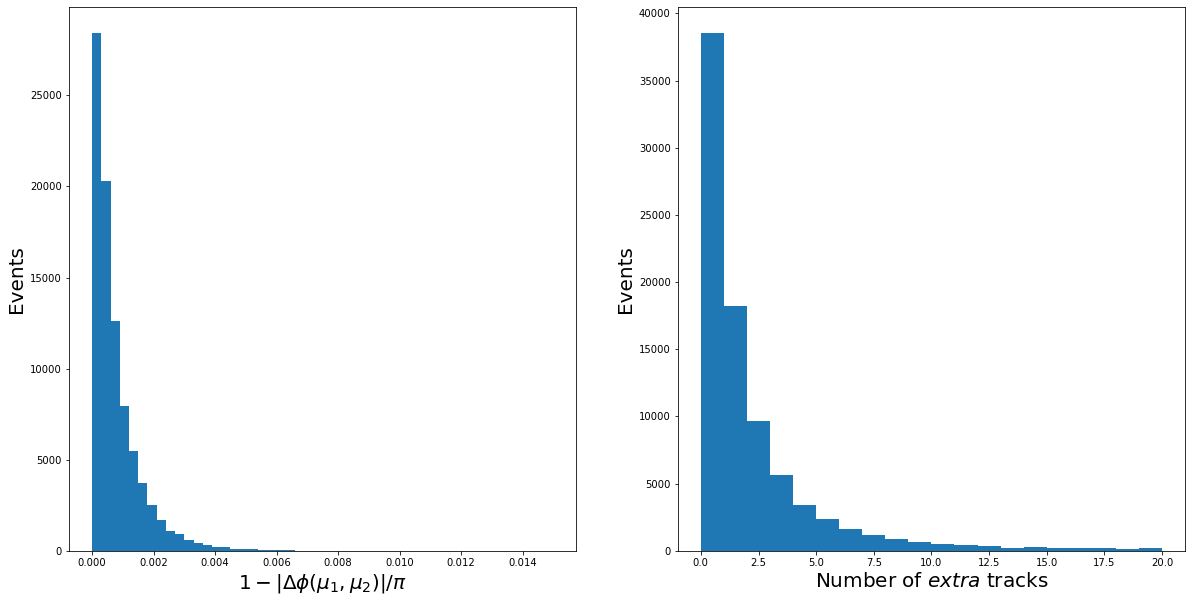

In [8]:
df_signal_events = df_signal.set_index( ["Run", "LumiSection", "EventNum"] ).drop( columns=['Xi', 'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2'] )
df_signal_events = df_signal_events[ ~df_signal_events.index.duplicated(keep='first') ]

msk_invmass = ( df_signal_events["InvMass"] >= 110. )
df_signal_events = df_signal_events[msk_invmass]

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist( df_signal_events["Acopl"], bins=50, range=(0.,0.015) )
axes[0].set_ylabel( "Events", fontsize=20 )
axes[0].set_xlabel( r"$1 - \vert\Delta\phi(\mu_1,\mu_2)\vert/\pi$", fontsize=20 )
axes[1].hist( df_signal_events["ExtraPfCands"], bins=20, range=(0,20) )
axes[1].set_ylabel( "Events", fontsize=20 )
axes[1].set_xlabel( r"Number of $\it{extra}$ tracks", fontsize=20 )

Text(0, 0.5, 'Y (mm)')

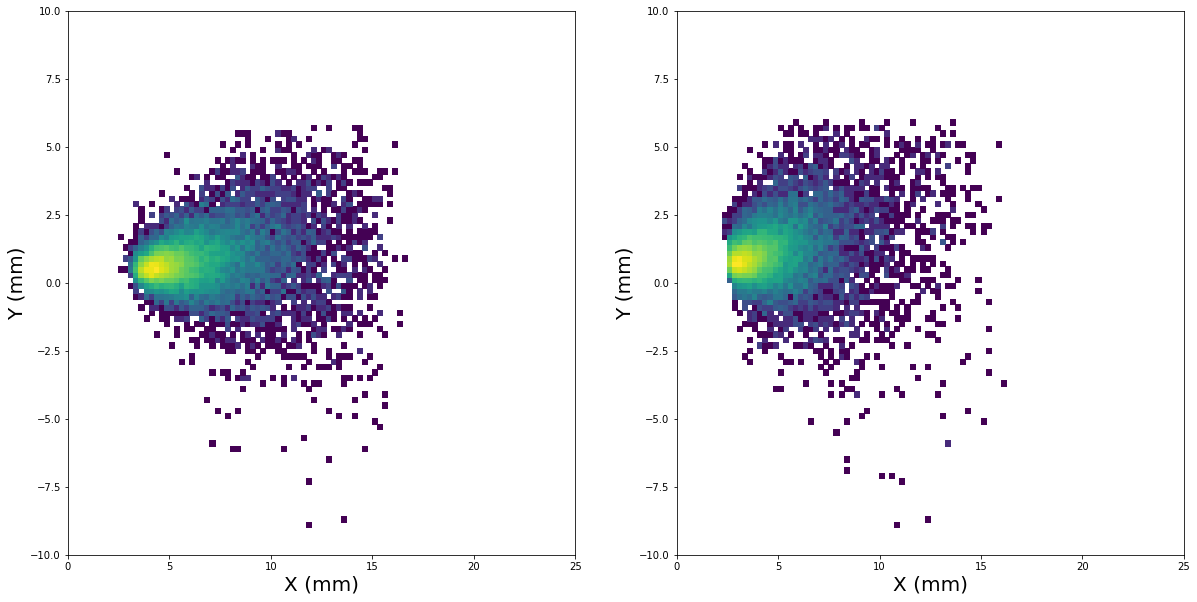

In [9]:
from matplotlib.colors import LogNorm

msk_excl = ( df_signal["InvMass"] >= 110. ) & ( df_signal["Acopl"] <= 0.009 ) & ( df_signal["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 1 )
    
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist2d( df_signal[ "TrackX1" ][ msk_protons_1 ], df_signal[ "TrackY1" ][ msk_protons_1 ], bins=(100,100), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[0].set_xlabel( "X (mm)", fontsize=20 )
axes[0].set_ylabel( "Y (mm)", fontsize=20 )
axes[1].hist2d( df_signal[ "TrackX1" ][ msk_protons_2 ], df_signal[ "TrackY1" ][ msk_protons_2 ], bins=(100,100), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[1].set_xlabel( "X (mm)", fontsize=20 )
axes[1].set_ylabel( "Y (mm)", fontsize=20 )

Proton selection: MultiRP
Number of protons: 16475, 15365


Text(0, 0.5, '$\\xi_{\\mu\\mu}$')

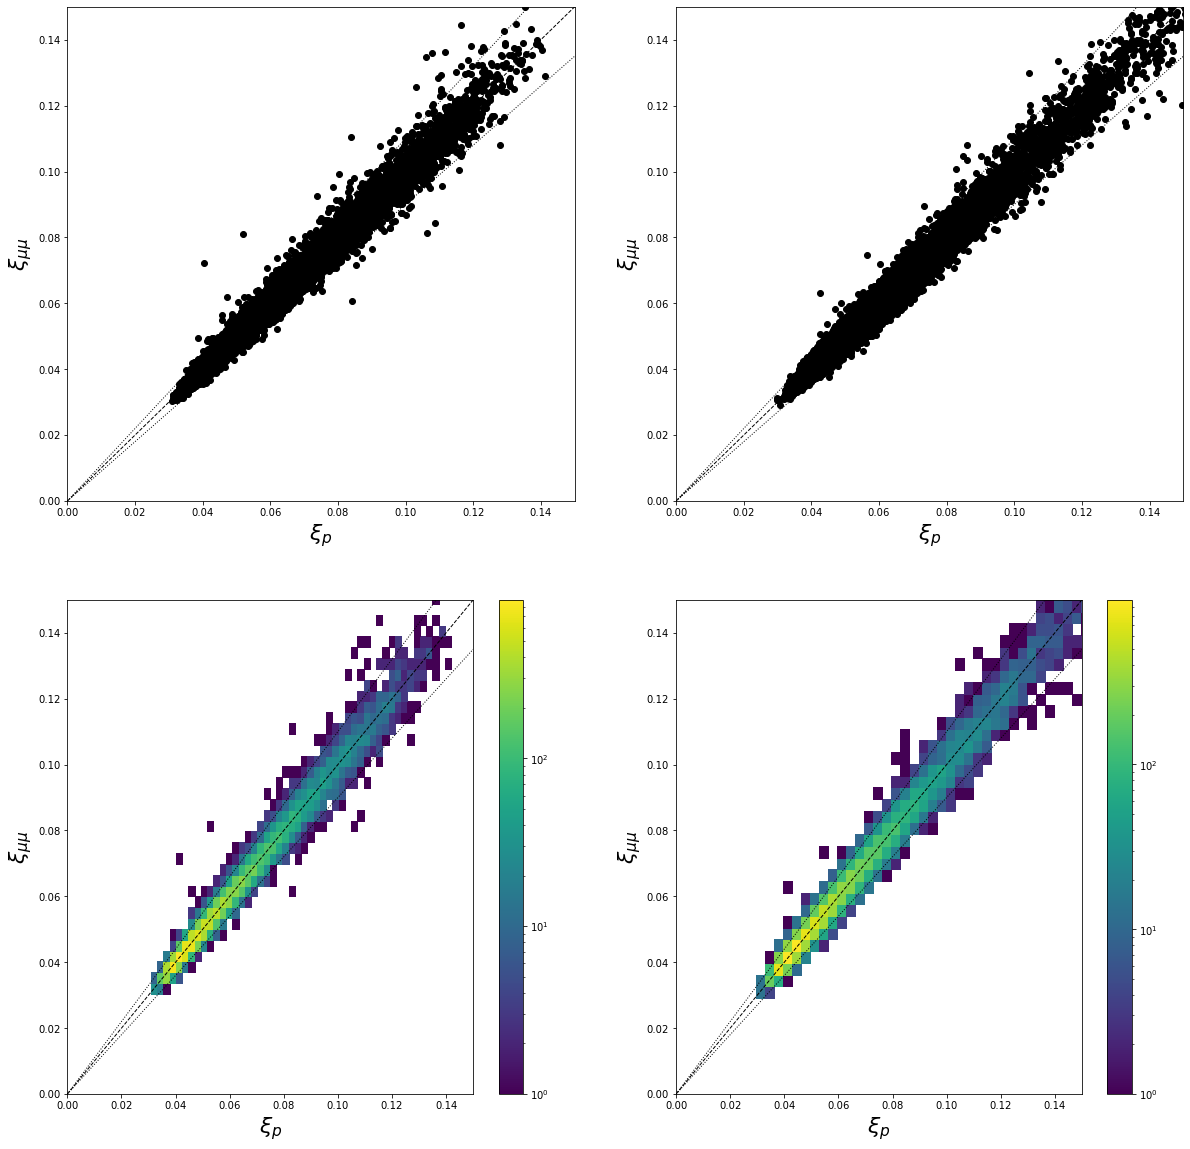

In [10]:
msk_excl = ( df_signal["InvMass"] >= 110. ) & ( df_signal["Acopl"] <= 0.009 ) & ( df_signal["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 1 )

print ( "Proton selection: {}".format( proton_selection ) )
print ( "Number of protons: {}, {}".format( len( df_signal[ "Xi" ][ msk_protons_1 ] ), len( df_signal[ "Xi" ][ msk_protons_2 ] ) ) )

fig, axes = plt.subplots( 2, 2, figsize=(20,20) )
axes[0,0].plot( df_signal[ "Xi" ][ msk_protons_1 ], df_signal[ "XiMuMuPlus" ][ msk_protons_1 ], 'ko' )
axes[0,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,0].set_xlim(0.,0.15)
axes[0,0].set_ylim(0.,0.15)
axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
#axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22, ha='right', x=1.0 )
#axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22, ha='right', y=1.0 )
axes[0,1].plot( df_signal[ "Xi" ][ msk_protons_2 ], df_signal[ "XiMuMuMinus" ][ msk_protons_2 ], 'ko' )
axes[0,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,1].set_xlim(0.,0.15)
axes[0,1].set_ylim(0.,0.15)
axes[0,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,0].hist2d( df_signal[ "Xi" ][ msk_protons_1 ], df_signal[ "XiMuMuPlus" ][ msk_protons_1 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,0])
axes[1,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,0].set_xlim(0.,0.15)
axes[1,0].set_ylim(0.,0.15)
axes[1,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,1].hist2d( df_signal[ "Xi" ][ msk_protons_2 ], df_signal[ "XiMuMuMinus" ][ msk_protons_2 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,1])
axes[1,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,1].set_xlim(0.,0.15)
axes[1,1].set_ylim(0.,0.15)
axes[1,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )

# Data

In [11]:
df_data_list = []
df_counts_data_list = []

for file_ in fileNames_data:
    print ( file_ )
    with h5py.File( file_, 'r' ) as f:    
        print ( list(f.keys()) )
        dset = f['protons']
        print ( dset.shape )
        print ( dset[:,:] )
    
        dset_columns = f['columns']
        print ( dset_columns.shape )
        columns = list( dset_columns )
        print ( columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        print ( columns_str )

        dset_selections = f['selections']
        selections_ = [ item.decode("utf-8") for item in dset_selections ]
        print ( selections_ )  
        
        dset_counts = f['event_counts']
        df_counts_data_list.append( pd.Series( dset_counts, index=selections_ ) )
        print ( df_counts_data_list[-1] )
    
        chunk_size = 1000000
        entries = dset.shape[0]
        start_ = list( range( 0, entries, chunk_size ) )
        stop_ = start_[1:]
        stop_.append( entries )
        print ( start_ )
        print ( stop_ )
        for idx in range( len( start_ ) ):
            print ( start_[idx], stop_[idx] )
            #print ( dset[ start_[idx] : stop_[idx] ] )
            df_ = pd.DataFrame( dset[ start_[idx] : stop_[idx] ], columns=columns_str )
            df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                        'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                        'Xi', 'T', 'ThX', 'ThY',
                        'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
            df_data_list.append( df_ )
            print ( df_data_list[-1].head() )
            print ( len( df_data_list[-1] ) )
            
print ( "Concatenating {} dataframes..".format( len( df_data_list ) ) )
df_data = pd.concat( df_data_list )
print ( "Total length: {} lines".format( len( df_data ) ) )
df_data[:20]

data/output-UL2017B-PreSel.h5
['columns', 'event_counts', 'protons', 'selections']
(107075, 38)
[[2.97227000e+05 5.30000000e+01 2.29700000e+03 ... 9.83012105e-01
  5.61954090e-02 4.09129155e-03]
 [2.97227000e+05 5.50000000e+01 8.67000000e+02 ... 1.32611728e-01
  1.95323438e-03 4.83462101e-02]
 [2.97227000e+05 5.50000000e+01 8.67000000e+02 ... 1.32611728e-01
  1.95323438e-03 4.83462101e-02]
 ...
 [2.99062000e+05 1.33000000e+02 1.72100000e+03 ... 6.64818845e-01
  3.52177158e-03 7.56784159e-02]
 [2.99062000e+05 1.33000000e+02 1.72100000e+03 ... 6.64818845e-01
  3.52177158e-03 7.56784159e-02]
 [2.99062000e+05 1.33000000e+02 1.72100000e+03 ... 6.64818845e-01
  3.52177158e-03 7.56784159e-02]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP',

All        5019495
Muon         47627
Vertex       43234
Protons      37801
dtype: int64
[0]
[150190]
0 150190
      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  305045          267  468495137          140.0        0 -999      3     -1   
1  305045          267  468495137          140.0        0 -999     23     -1   
2  305045          267  468495137          140.0        0 -999    123     -1   
3  305045          267  468495137          140.0        0 -999    123     -1   
4  305045          267  468495137          140.0        1    0      3     23   

    TrackX1   TrackY1  ...         T       ThX       ThY    Muon0Pt  \
0  6.077637  3.556885  ... -1.668108  0.000000 -0.000205  94.437912   
1  6.021545  3.854736  ... -1.630161  0.000000 -0.000202  94.437912   
2  5.710632  0.338715  ... -0.010741  0.000000 -0.000011  94.437912   
3  6.580200  2.045654  ... -0.123151  0.000000 -0.000055  94.437912   
4  6.077637  3.556885  ... -0.826229 -0.000046 -0.000

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,T,ThX,ThY,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,297227,53,36577201,120.0,0,-999,123,-1,2.333649,0.503052,...,-0.659534,0.000000,-0.000127,132.996933,63.807861,12.129827,48,0.983012,0.056195,0.004091
1,297227,55,38079658,120.0,0,-999,103,-1,4.577393,1.367676,...,-0.327952,0.000000,-0.000090,63.340645,62.493637,123.616515,27,0.132612,0.001953,0.048346
2,297227,55,38079658,120.0,0,-999,123,-1,4.395691,1.493408,...,-0.332531,0.000000,-0.000091,63.340645,62.493637,123.616515,27,0.132612,0.001953,0.048346
3,297227,55,38079658,120.0,1,1,103,123,4.577393,1.367676,...,-0.160121,-0.000061,-0.000014,63.340645,62.493637,123.616515,27,0.132612,0.001953,0.048346
4,297227,56,38791639,120.0,0,-999,103,-1,8.585938,2.644531,...,-0.184990,0.000000,-0.000068,65.270454,65.022888,152.786010,29,0.058782,0.002211,0.062855
5,297227,56,38791639,120.0,0,-999,123,-1,8.483521,2.801025,...,-0.181088,0.000000,-0.000067,65.270454,65.022888,152.786010,29,0.058782,0.002211,0.062855
6,297227,56,38791639,120.0,1,1,103,123,8.585938,2.644531,...,-0.039719,-0.000015,0.000024,65.270454,65.022888,152.786010,29,0.058782,0.002211,0.062855
7,297227,56,38604580,120.0,0,-999,3,-1,4.131104,0.797180,...,-0.663142,0.000000,-0.000128,74.027679,70.969543,90.916580,28,0.588286,0.003354,0.038210
8,297227,56,38604580,120.0,0,-999,23,-1,4.206665,0.942139,...,-0.536933,0.000000,-0.000115,74.027679,70.969543,90.916580,28,0.588286,0.003354,0.038210
9,297227,56,38604580,120.0,0,-999,103,-1,3.514526,1.507568,...,-1.146207,0.000000,-0.000168,74.027679,70.969543,90.916580,28,0.588286,0.003354,0.038210


In [12]:
df_counts_data = df_counts_data_list[0];
for idx in range( 1, len(df_counts_data_list) ):
    df_counts_data = df_counts_data.add( df_counts_data_list[idx] )
df_counts_data

All        31108565
Muon         308240
Vertex       285916
Protons      223649
dtype: int64

Text(0, 0.5, 'Y (mm)')

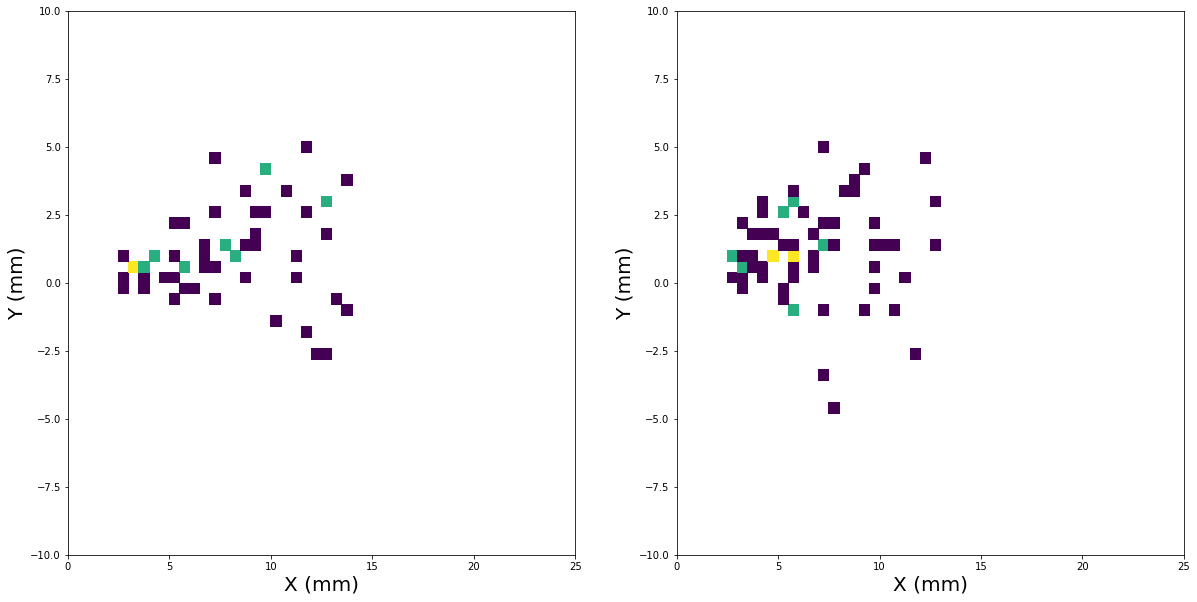

In [13]:
msk_excl = ( df_data["InvMass"] >= 110. ) & ( df_data["Acopl"] <= 0.009 ) & ( df_data["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )
    
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist2d( df_data[ "TrackX1" ][ msk_protons_1 ], df_data[ "TrackY1" ][ msk_protons_1 ], bins=(50,50), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[0].set_xlabel( "X (mm)", fontsize=20 )
axes[0].set_ylabel( "Y (mm)", fontsize=20 )
axes[1].hist2d( df_data[ "TrackX1" ][ msk_protons_2 ], df_data[ "TrackY1" ][ msk_protons_2 ], bins=(50,50), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[1].set_xlabel( "X (mm)", fontsize=20 )
axes[1].set_ylabel( "Y (mm)", fontsize=20 )

Proton selection: MultiRP
Number of protons: 57, 67


Text(0, 0.5, '$\\xi_{\\mu\\mu}$')

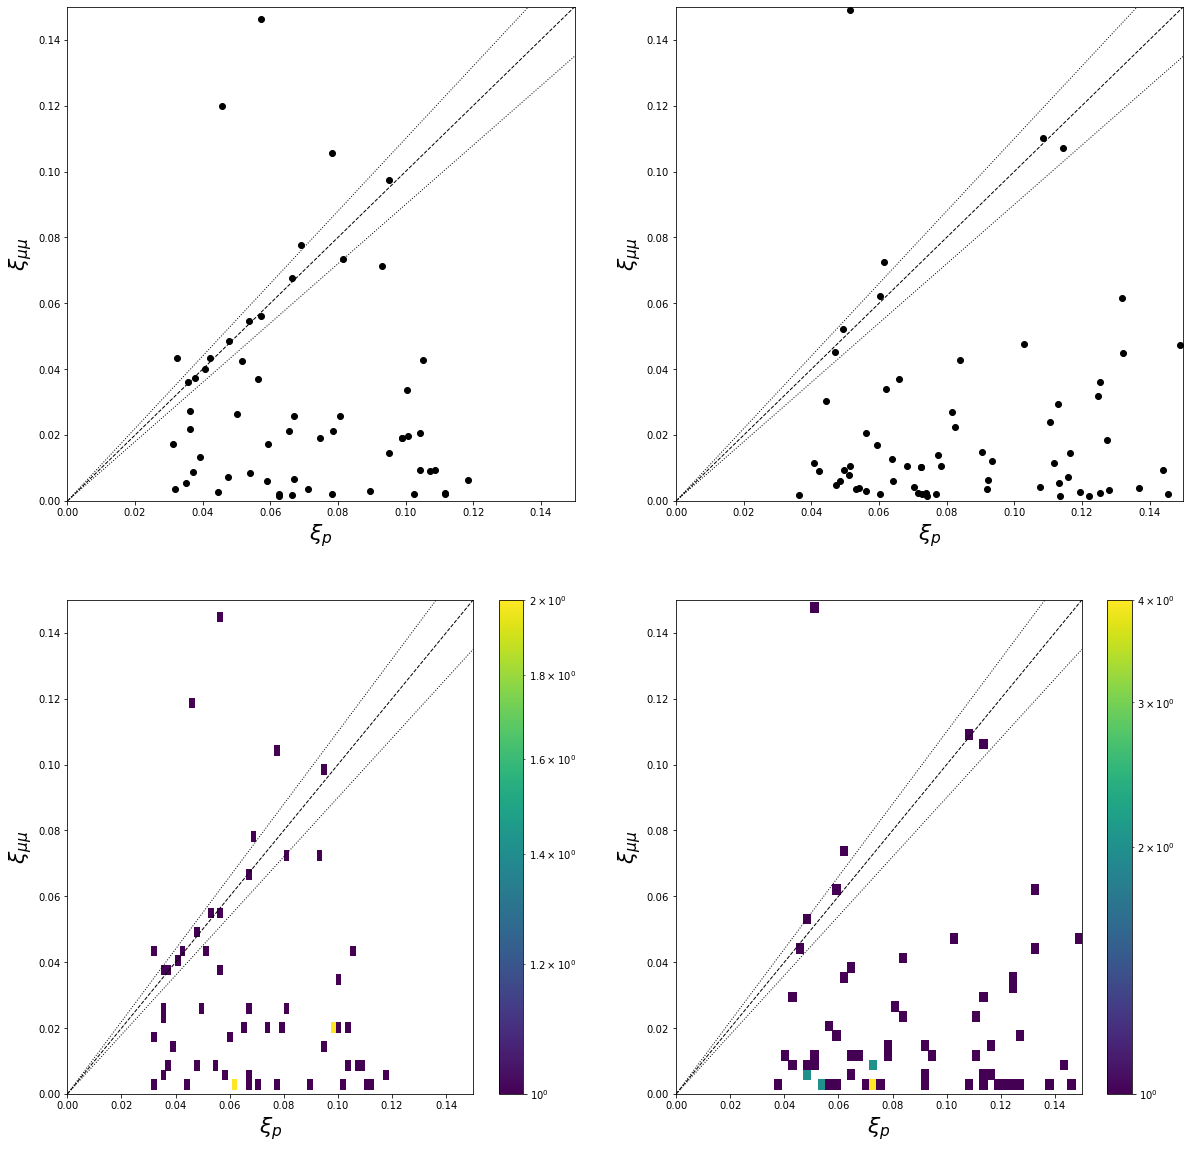

In [14]:
msk_excl = ( df_data["InvMass"] >= 110. ) & ( df_data["Acopl"] <= 0.009 ) & ( df_data["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )

print ( "Proton selection: {}".format( proton_selection ) )
print ( "Number of protons: {}, {}".format( len( df_data[ "Xi" ][ msk_protons_1 ] ), len( df_data[ "Xi" ][ msk_protons_2 ] ) ) )

fig, axes = plt.subplots( 2, 2, figsize=(20,20) )
axes[0,0].plot( df_data[ "Xi" ][ msk_protons_1 ], df_data[ "XiMuMuPlus" ][ msk_protons_1 ], 'ko' )
axes[0,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,0].set_xlim(0.,0.15)
axes[0,0].set_ylim(0.,0.15)
axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
axes[0,1].plot( df_data[ "Xi" ][ msk_protons_2 ], df_data[ "XiMuMuMinus" ][ msk_protons_2 ], 'ko' )
axes[0,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,1].set_xlim(0.,0.15)
axes[0,1].set_ylim(0.,0.15)
axes[0,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,0].hist2d( df_data[ "Xi" ][ msk_protons_1 ], df_data[ "XiMuMuPlus" ][ msk_protons_1 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,0])
axes[1,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,0].set_xlim(0.,0.15)
axes[1,0].set_ylim(0.,0.15)
axes[1,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,1].hist2d( df_data[ "Xi" ][ msk_protons_2 ], df_data[ "XiMuMuMinus" ][ msk_protons_2 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,1])
axes[1,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,1].set_xlim(0.,0.15)
axes[1,1].set_ylim(0.,0.15)
axes[1,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )

### Select dilepton candidates in diagonal

[0 0 0 2 2 0 0 0 1 0 1 1 1 0 2 2 0 2 0 0 2 1 1 3 4 7 2 0 2 0 0 0 0 0 0 0 0
 0 0 0] [-5.  -4.8 -4.6 -4.4 -4.2 -4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4
 -2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4
  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3. ]
[0 0 1 1 1 1 1 1 0 0 2 1 3 0 2 1 1 0 0 2 2 1 1 0 2 4 0 0 1 0 0 0 0 0 0 0 0
 0 0 0] [-5.  -4.8 -4.6 -4.4 -4.2 -4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4
 -2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4
  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3. ]
y max. = 12.291502622129181


Text(0, 0.5, 'Events')

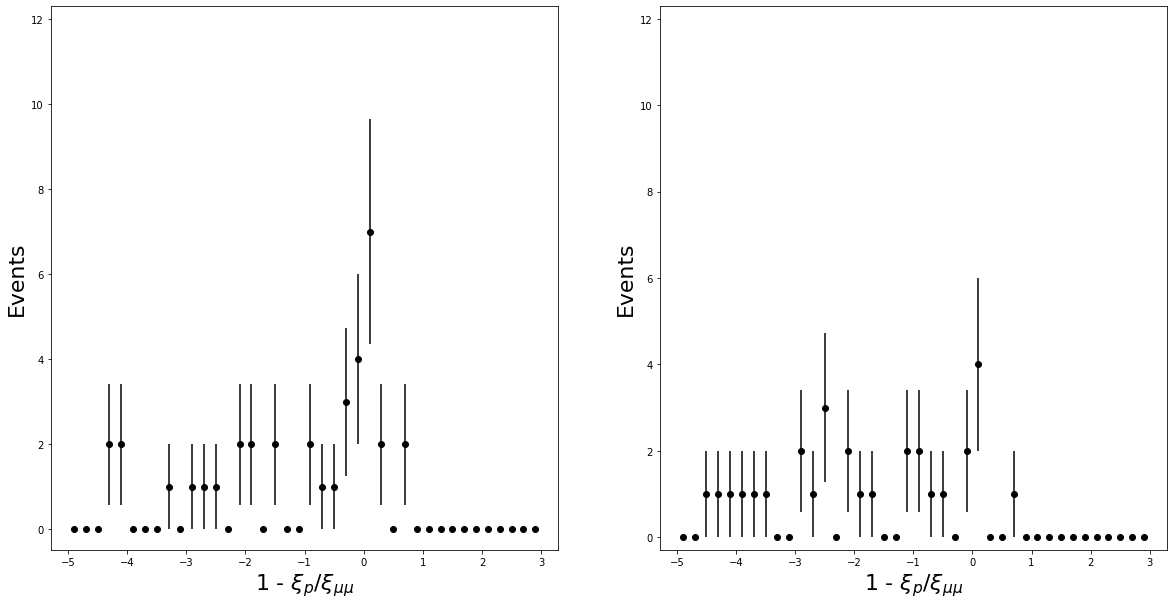

In [15]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

bins_ = 40
range_ = (-5.,3.)

msk_excl = ( df_data["InvMass"] >= 110. ) & ( df_data["Acopl"] <= 0.009 ) & ( df_data["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )
    
vals_1 = ( 1. - df_data[ "Xi" ][ msk_protons_1 ] / df_data[ "XiMuMuPlus" ][ msk_protons_1 ] )
counts_1, bin_edges_1 = np.histogram( vals_1, bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
print ( counts_1, bin_edges_1 )

bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='ko')

vals_2 = ( 1. - df_data[ "Xi" ][ msk_protons_2 ] / df_data[ "XiMuMuMinus" ][ msk_protons_2 ] )
counts_2, bin_edges_2 = np.histogram( vals_2, bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
print ( counts_2, bin_edges_2 )

bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='ko')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

axes[0].set_ylim( top=y_max )
axes[0].set_xlabel( r"1 - $\xi_p / \xi_{\mu\mu}$", fontsize=22 )
axes[0].set_ylabel( "Events", fontsize=22 )
axes[1].set_ylim( top=y_max )
axes[1].set_xlabel( r"1 - $\xi_p / \xi_{\mu\mu}$", fontsize=22 )
axes[1].set_ylabel( "Events", fontsize=22 )

5785      0.066331
39811     0.053652
45170     0.040781
936       0.057313
93817     0.081479
157144    0.095002
197500    0.035533
41932     0.047875
131830    0.069130
207208    0.042309
221452    0.037863
Name: Xi, dtype: float64
101961    0.047040
47139     0.114364
102511    0.108525
183292    0.049287
254521    0.060402
231920    0.061514
Name: Xi, dtype: float64
y max. = 9.47213595499958
5785      0.000026
39811     0.000088
45170    -0.000064
936       0.000047
93817    -0.000030
157144    0.000017
197500    0.000017
41932     0.000038
131830    0.000134
207208    0.000062
221452    0.000007
Name: ThX, dtype: float64
101961    0.000113
47139     0.000029
102511   -0.000069
183292    0.000063
254521   -0.000008
231920    0.000094
Name: ThX, dtype: float64
y max. = 13.65685424949238
5785     -1.711910e-05
39811     7.711315e-07
45170    -5.318766e-05
936       3.860024e-06
93817    -1.272517e-05
157144   -3.580272e-05
197500   -5.277169e-05
41932     2.561156e-06
131830   -4.784

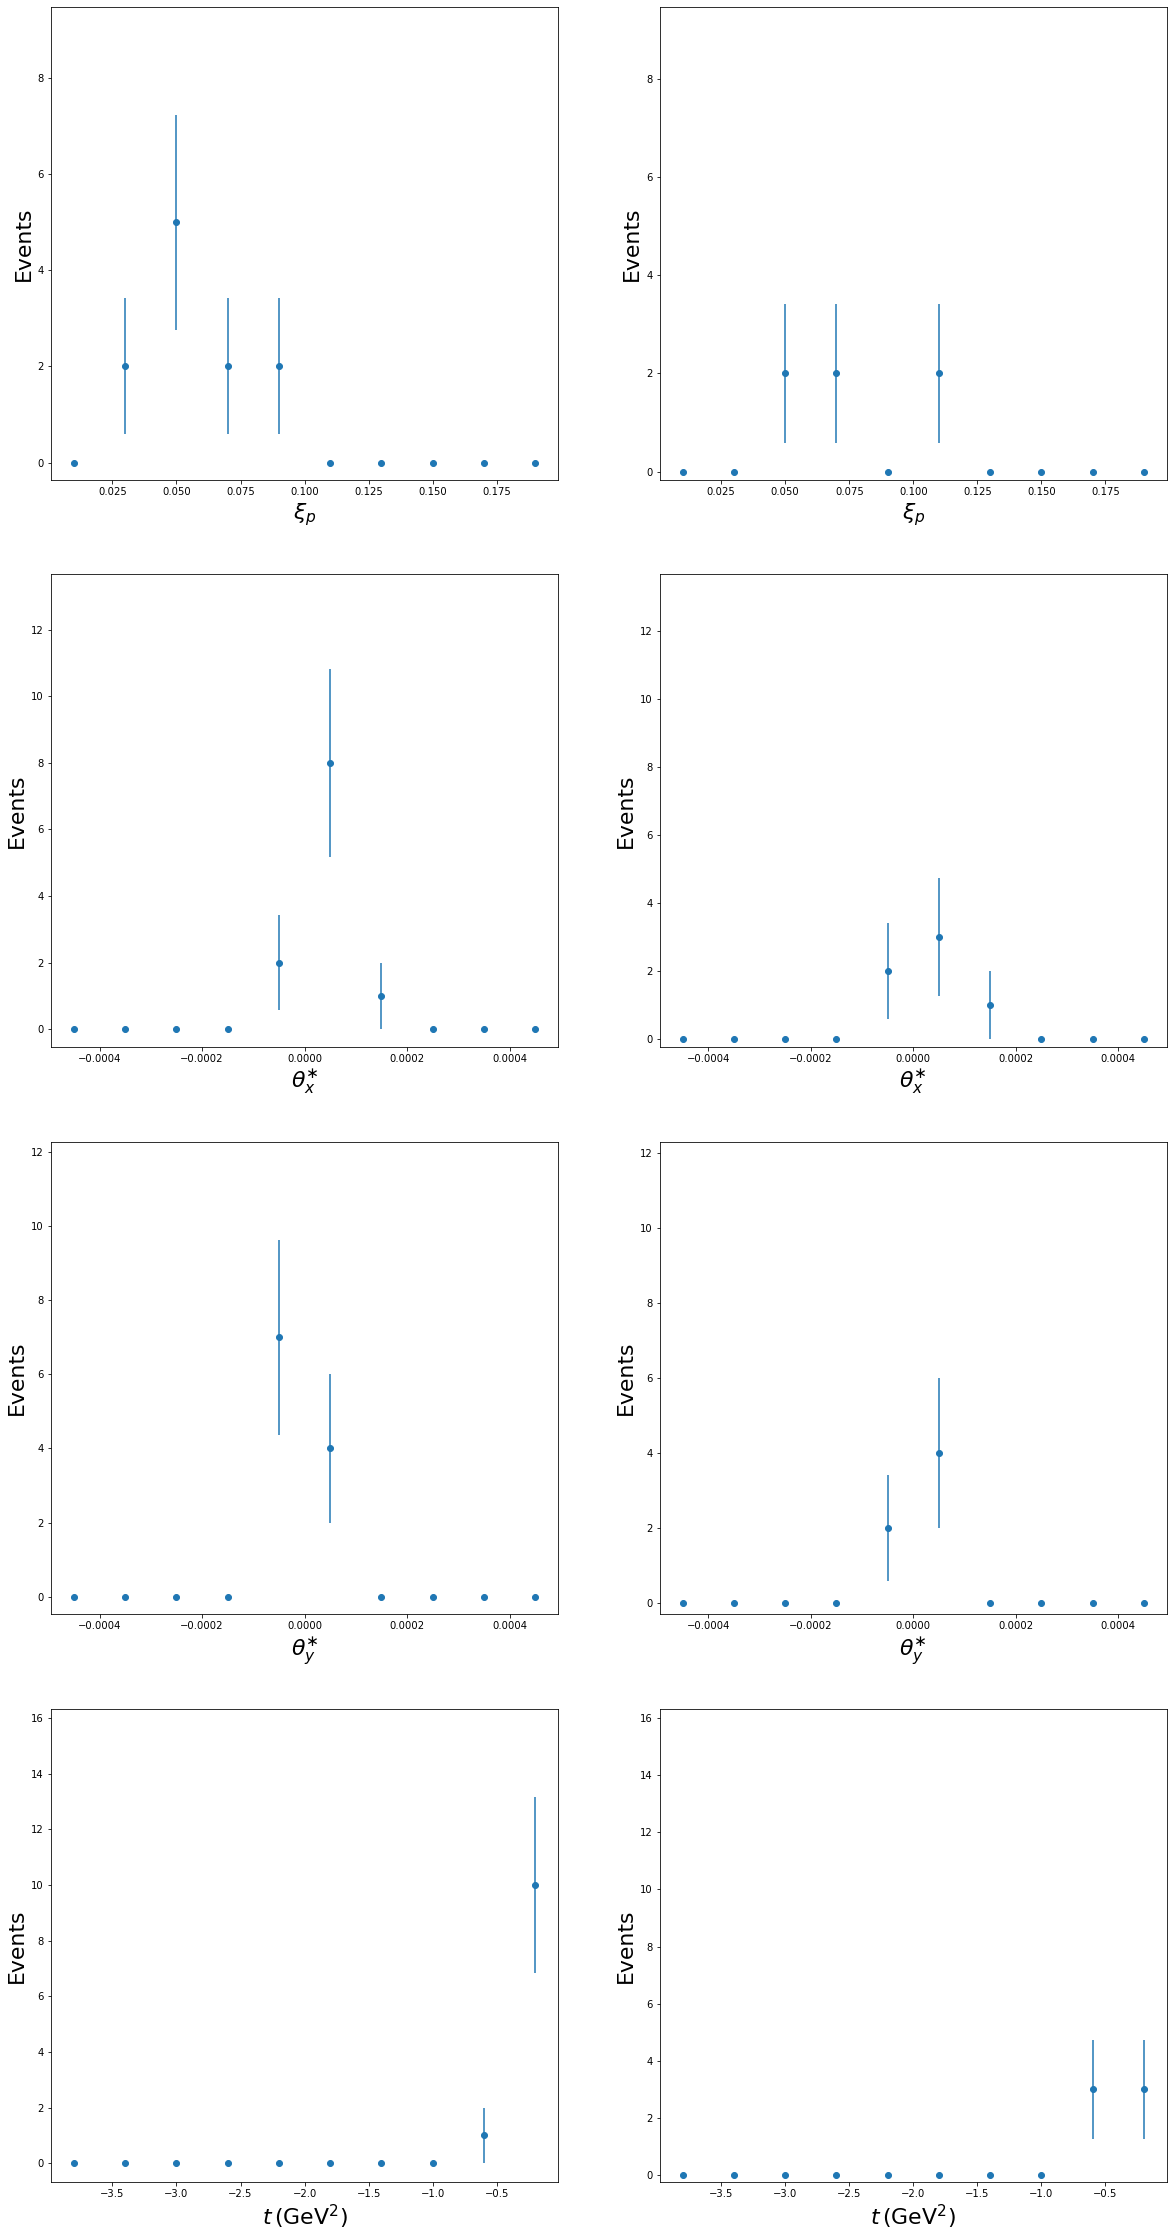

In [16]:
msk1_data_sel = ( vals_1 >= -0.20 ) & ( vals_1 <= +0.20 )
msk2_data_sel = ( vals_2 >= -0.20 ) & ( vals_2 <= +0.20 )

vars_ = {
    "Xi": { "var" : "Xi", "bins" : 10, "range" : (0.,0.2), "xlabel" : r"$\xi_p$" },
    "ThX": { "var" : "ThX", "bins" : 10, "range" : (-0.0005,0.0005), "xlabel" : r"$\theta_x^{\ast}$" },
    "ThY": { "var" : "ThY", "bins" : 10, "range" : (-0.0005,0.0005), "xlabel" : r"$\theta_y^{\ast}$" },
    "T": { "var" : "T", "bins" : 10, "range" : (-4.,0.), "xlabel" : r"$t\,(\mathrm{GeV}^2)$" }
    }

fig, axes = plt.subplots( len( vars_ ), 2, figsize=( 20, 10*len( vars_ ) ) )

row_ = 0
for key_ in vars_:

    var_ = vars_[ key_ ][ "var" ]
    bins_ = vars_[ key_ ][ "bins" ]
    range_ = vars_[ key_ ][ "range" ]
    xlabel_ = vars_[ key_ ][ "xlabel" ]
    
    print ( df_data[ var_ ][ msk_protons_1 ][ msk1_data_sel ] )

    counts_1, bin_edges_1 = np.histogram( df_data[ var_ ][ msk_protons_1 ][ msk1_data_sel ], bins=bins_, range=range_ )
    errors_1 = np.sqrt( counts_1 )
    bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
    axes[ row_, 0 ].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o')

    print ( df_data[ var_ ][ msk_protons_2 ][ msk2_data_sel ] )

    counts_2, bin_edges_2 = np.histogram( df_data[ var_ ][ msk_protons_2 ][ msk2_data_sel ], bins=bins_, range=range_ )
    errors_2 = np.sqrt( counts_2 )
    bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
    axes[ row_, 1 ].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o')

    idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
    y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
    print ( "y max. = {}".format(y_max) )

    axes[ row_, 0 ].set_ylim( top=y_max )
    axes[ row_, 0 ].set_xlabel( xlabel_, fontsize=22 )
    axes[ row_, 0 ].set_ylabel( "Events", fontsize=22 )
    axes[ row_, 1 ].set_ylim( top=y_max )
    axes[ row_, 1 ].set_xlabel( xlabel_, fontsize=22 )
    axes[ row_, 1 ].set_ylabel( "Events", fontsize=22 )
    
    row_ += 1
    